In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from transformers import pipeline
from catboost import Pool

In [2]:
df = pd.read_csv('../input/craigslist-carstrucks-data/vehicles.csv')
df = df.drop('Unnamed: 0', axis=1).set_index('id')

In [3]:
df = df.drop(
                ['url', 'region_url', 'image_url', 'VIN', 'long', 'lat'], 
                axis=1
            )

In [4]:
missing_df = pd.concat(
    [
        df.isna().sum().rename('# missing'),
        df.isna().sum().div(df.shape[0]).mul(100).round(2).rename('% missing')
    ], axis=1
)

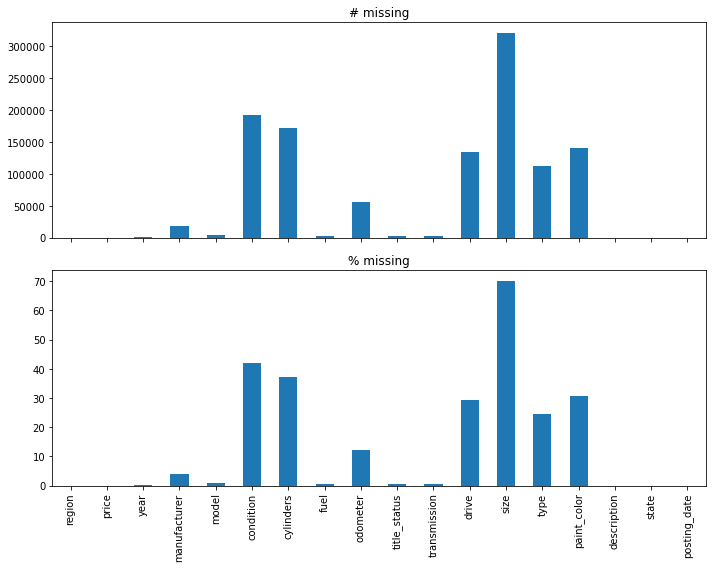

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       figsize=(10, 8),
                       sharex=True)

missing_df['# missing'].plot(kind='bar', ax=ax[0], title='# missing')
missing_df['% missing'].plot(kind='bar', ax=ax[1], title='% missing')
plt.tight_layout()
plt.show();

size and condition are missing >40% values

In [6]:
df.nunique()

region             405
price            16924
year               110
manufacturer        43
model            31520
condition            6
cylinders            8
fuel                 5
odometer        108135
title_status         6
transmission         3
drive                3
size                 4
type                13
paint_color         12
description     384347
state               51
posting_date    423805
dtype: int64

In [7]:
df['price'].describe().to_frame().astype(str)

,price
count,458213.0
mean,40420.93069598637
std,8194598.603664957
min,0.0
25%,4900.0
50%,10995.0
75%,21495.0
max,3615215112.0


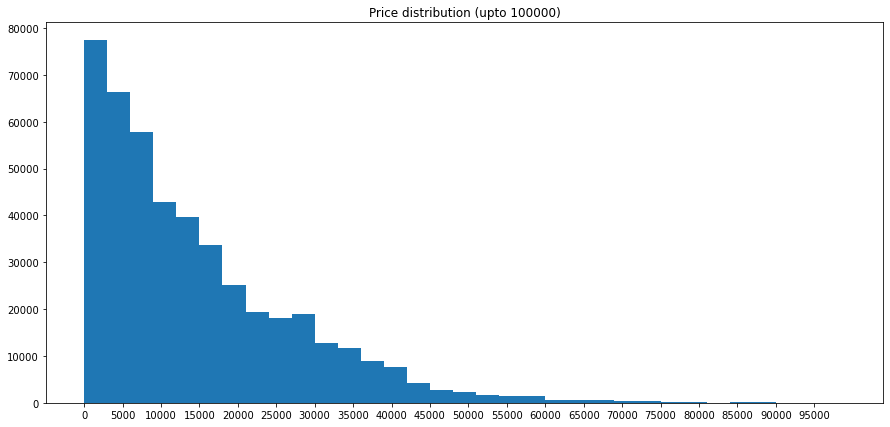

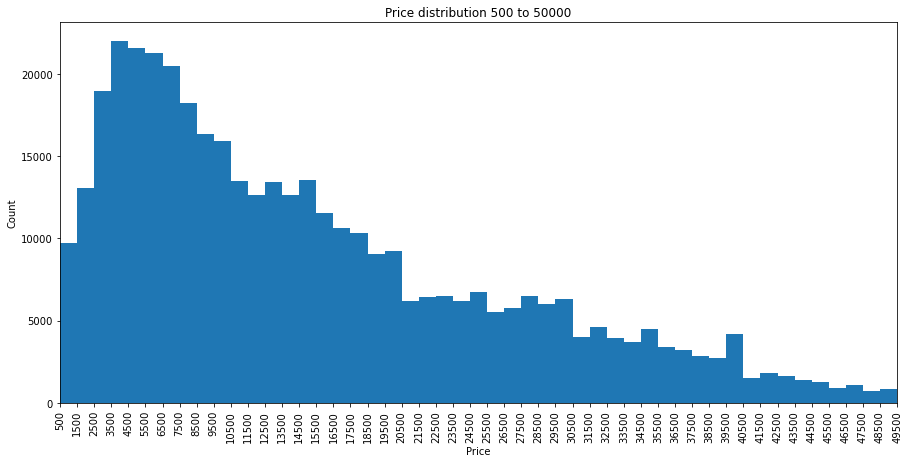

In [8]:
plt.rcParams['figure.figsize'] = 15, 7
bins_ = np.arange(0, 100000+1, 3000)
plt.hist(df['price'], bins=bins_)
plt.title('Price distribution (upto 100000)')
plt.xticks(np.arange(0, 100000, 5000))
plt.show()
bins_ = np.arange(500, 50000 + 1, 1000).tolist()
plt.hist(df['price'], bins=bins_);
plt.xlim(bins_[0], bins_[-1])
plt.xticks(bins_, rotation=90)
plt.title('Price distribution 500 to 50000');
plt.xlabel('Price')
plt.ylabel('Count');

Most of the cars are in 3500-4500 range

In [9]:
df['year'].describe().to_frame()

,year
count,457163.000000
mean,2010.746067
std,8.868136
min,1900.000000
25%,2008.000000
50%,2013.000000
75%,2016.000000
max,2021.000000


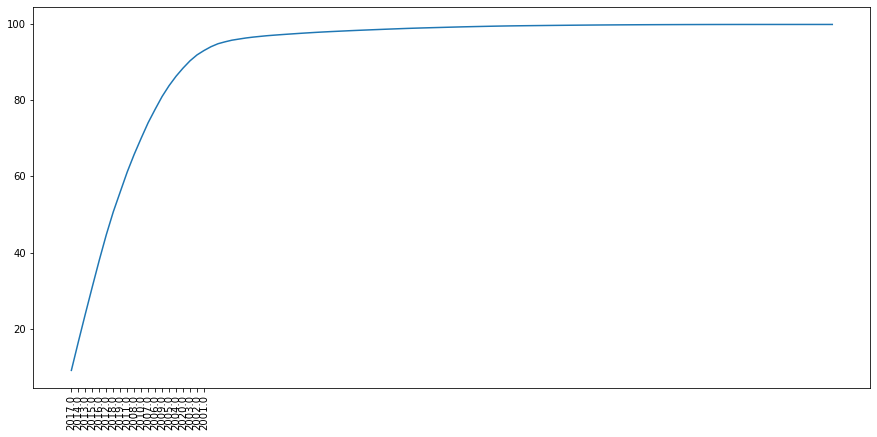

In [10]:
cumsum_df = np.cumsum(df.groupby('year')['region'].count().div(df.shape[0]).mul(100).sort_values(ascending=False))
x = cumsum_df.index.astype(str)
y = cumsum_df.values
plt.plot(x, y)
plt.xticks(x[:20], rotation=90);

In [11]:
df['manufacturer'].value_counts(normalize=True).mul(100).to_frame().reset_index().sort_values(by='index')

,index,manufacturer
21,acura,0.910924
35,alfa-romeo,0.042501
39,aston-martin,0.007955
20,audi,1.268884
9,bmw,2.807317
18,buick,1.365704
17,cadillac,1.532524
1,chevrolet,14.767735
15,chrysler,1.704345
38,datsun,0.014318


Source: https://www.consumerreports.org/cars-who-owns-which-car-brands/
and Google searches

In [12]:
company_parent_map = {
     'acura': 'honda',
     'alfa-romeo': 'stellantis',
     'aston-martin': 'aston martin',
     'audi': 'volkswagen',
     'bmw': 'bmw',
     'buick': 'gmc',
     'cadillac': 'gmc',
     'chevrolet': 'gmc',
     'chrysler': 'stellantis',
     'datsun': 'rnm',
     'dodge': 'stellantis',
     'ferrari': 'ferrari',
     'fiat': 'stellantis',
     'ford': 'ford',
     'gmc': 'gmc',
     'harley-davidson': 'invalid',
     'hennessey': 'hennessey',
     'honda': 'honda',
     'hyundai': 'hyundai',
     'infiniti': 'rnm',
     'jaguar': 'tata',
     'jeep': 'stellantis',
     'kia': 'hyundai',
     'land rover': 'tata',
     'lexus': 'toyota',
     'lincoln': 'ford',
     'mazda': 'mazda',
     'mercedes-benz': 'daimler',
     'mercury': 'ford',
     'mini': 'bmw',
     'mitsubishi': 'rnm',
     'morgan': 'morgan',
     'nissan': 'rnm',
     'pontiac': 'gmc',
     'porsche': 'volkswagen',
     'ram': 'stellantis',
     'rover': 'tata',
     'saturn': 'gmc',
     'subaru': 'subaru',
     'tesla': 'tesla',
     'toyota': 'toyota',
     'volkswagen': 'volkswagen',
     'volvo': 'volvo'
}

In [13]:
df['manufacturer'] = df['manufacturer'].replace('rover', 'land rover')
df = df[df['manufacturer'] != 'harley-davidson']

In [14]:
df['car_parent_company'] = ''
df.loc[:, 'car_parent_company'] = df['manufacturer'].map(company_parent_map)

In [15]:
df['car_parent_company'].value_counts()

gmc             99426
ford            84649
stellantis      64233
toyota          45696
honda           29876
rnm             29732
hyundai         19829
volkswagen      17851
bmw             14682
daimler         10628
subaru          10510
mazda            5931
volvo            2866
tata             2743
tesla            1067
ferrari            96
aston martin       35
morgan              3
hennessey           1
Name: car_parent_company, dtype: int64

Drop 0 priced cars

In [16]:
df = df[df['price'] != 0]

In [17]:
df['year_posted'] = df['posting_date'].str[:4].astype(float)

In [18]:
df['age_on_post'] = df['year_posted'] - df['year']

In [19]:
df.isna().sum().div(df.shape[0]).mul(100).round(2).rename('% missing').to_frame()

,% missing
region,0.00
price,0.00
year,0.24
manufacturer,3.92
model,1.03
condition,40.20
cylinders,36.37
fuel,0.63
odometer,11.57
title_status,0.45


In [20]:
df['fuel_wo_na'] = df['fuel'].fillna('gas')

In [21]:
df['odometer'].describe().astype(str)

count              375224.0
mean     103777.73510756242
std       3345562.880135601
min                     0.0
25%                 42000.0
50%                 89655.5
75%               136000.25
max            2043755555.0
Name: odometer, dtype: object

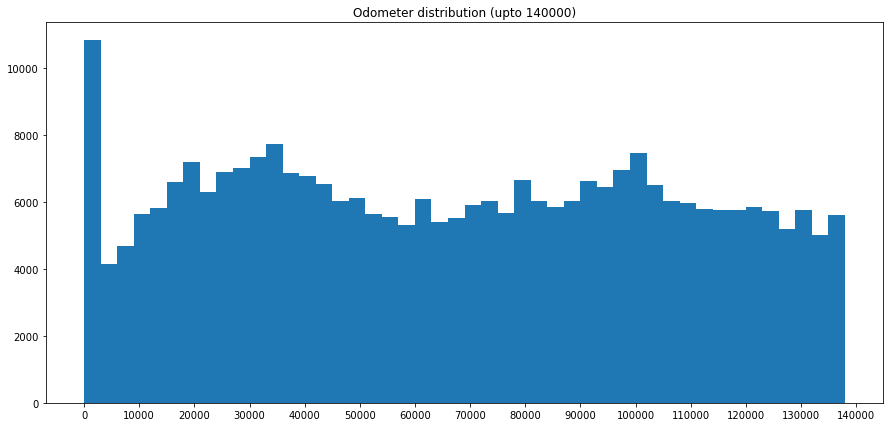

In [22]:
plt.rcParams['figure.figsize'] = 15, 7
bins_ = np.arange(0, 140000+1, 3000)
plt.hist(df['odometer'], bins=bins_)
plt.title('Odometer distribution (upto 140000)')
plt.xticks(np.arange(0, 140000+1, 10000))
plt.show()

In [23]:
df['condition'] = df['condition'].replace('like new', 'excellent')

If the odometer is at 0, the car must be new

In [24]:
df.loc[df['odometer'] == 0, 'condition'] = 'excellent'

In [25]:
df.loc[df['odometer'] == 0, 'title_status'] = 'clean'

In [26]:
df['title_status'] = df['title_status'].replace('parts only', 'salvage')

In [27]:
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'description', 'state',
       'posting_date', 'car_parent_company', 'year_posted', 'age_on_post',
       'fuel_wo_na'],
      dtype='object')

In [28]:
df2 = df.copy()

In [29]:
df2 = df2[(df2['price'] <= 40000) & (df2['price'] > 500)]

In [30]:
full_size_mask = df2['type'].isin(['sedan', 'SUV', 'pickup', 'truck', 'bus', 'mini-van', 'wagon', 'van'])
df2.loc[full_size_mask, 'size'] = 'full-size'
mid_size_mask  = df2['type'].isin(['offroad', 'coupe', 'convertible'])
df2.loc[mid_size_mask, 'size']  = 'mid_size'

In [31]:
X = df2[['age_on_post', 'year', 'car_parent_company',\
         'fuel_wo_na', 'drive', 'condition',\
         'odometer', 'title_status', 'transmission', 'size',\
         'state', 'region', 'paint_color', 'manufacturer']]
y = df2['price']

In [32]:
x_train_idx = X.sample(frac=0.8, random_state=21).index
X_train     = X.loc[x_train_idx]
X_test      = X.drop(x_train_idx)

y_train     = y.loc[x_train_idx]
y_test      = y.drop(x_train_idx)

In [33]:
X_train['car_parent_company'] = X_train['car_parent_company'].fillna('na')
X_train['drive'] = X_train['drive'].fillna('na')
X_train['condition'] = X_train['condition'].fillna('na')
X_train['title_status'] = X_train['title_status'].fillna('na')
X_train['transmission'] = X_train['transmission'].fillna('na')
X_train['size'] = X_train['size'].fillna('na')
X_train['state'] = X_train['state'].fillna('na')
X_train['paint_color'] = X_train['paint_color'].fillna('na')
X_train['manufacturer'] = X_train['manufacturer'].fillna('na')

In [34]:
X_test['car_parent_company'] = X_test['car_parent_company'].fillna('na')
X_test['drive'] = X_test['drive'].fillna('na')
X_test['condition'] = X_test['condition'].fillna('na')
X_test['title_status'] = X_test['title_status'].fillna('na')
X_test['transmission'] = X_test['transmission'].fillna('na')
X_test['size'] = X_test['size'].fillna('na')
X_test['state'] = X_test['state'].fillna('na')
X_test['paint_color'] = X_test['paint_color'].fillna('na')
X_test['manufacturer'] = X_test['manufacturer'].fillna('na')

<AxesSubplot:>

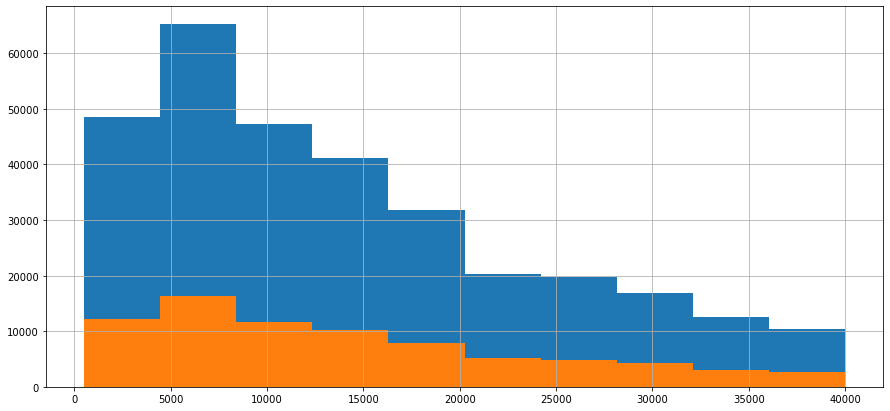

In [35]:
ax = y_train.hist()
y_test.hist(ax=ax)

In [36]:
# target_scaler = MinMaxScaler()

# target_scaler.fit(y_train.values.reshape(-1, 1))

# y_train_scaled = target_scaler.transform(y_train.values.reshape(-1, 1)).ravel()
# y_test_scaled  = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

In [37]:
cat_features = ['car_parent_company', 'fuel_wo_na', 'drive', 'condition', 'title_status', 'transmission', 'state', 'size', 'region', 'paint_color', 'manufacturer']

In [78]:
model = CatBoostRegressor(
                            iterations=5500, 
                            learning_rate=0.5,
                            loss_function='RMSE',
                            verbose=10,
                            early_stopping_rounds=5,
                            cat_features=cat_features,
                            random_state=21,
                            l2_leaf_reg=0,
                        )

In [79]:
model.fit(X_train, y_train)

0:	learn: 7655.6358481	total: 454ms	remaining: 41m 36s
10:	learn: 5446.3977479	total: 4.35s	remaining: 36m 10s
20:	learn: 5243.1149744	total: 8.05s	remaining: 35m 1s
30:	learn: 5124.8791326	total: 12.1s	remaining: 35m 33s
40:	learn: 5030.0877299	total: 16s	remaining: 35m 29s
50:	learn: 4944.4574003	total: 19.7s	remaining: 35m 4s
60:	learn: 4888.6087333	total: 23.4s	remaining: 34m 49s
70:	learn: 4856.8530693	total: 27.1s	remaining: 34m 30s
80:	learn: 4830.1743294	total: 30.6s	remaining: 34m 7s
90:	learn: 4798.6207369	total: 34.2s	remaining: 33m 55s
100:	learn: 4769.0860423	total: 37.9s	remaining: 33m 43s
110:	learn: 4746.8665071	total: 41.4s	remaining: 33m 28s
120:	learn: 4724.8653704	total: 45.2s	remaining: 33m 28s
130:	learn: 4702.5247752	total: 49.1s	remaining: 33m 30s
140:	learn: 4681.7049614	total: 52.5s	remaining: 33m 16s
150:	learn: 4663.8665910	total: 56.1s	remaining: 33m 8s
160:	learn: 4648.8080499	total: 59.9s	remaining: 33m 7s
170:	learn: 4629.1653321	total: 1m 3s	remaining: 

1420:	learn: 3980.4696598	total: 8m 50s	remaining: 25m 23s
1430:	learn: 3977.9949405	total: 8m 54s	remaining: 25m 19s
1440:	learn: 3975.9562954	total: 8m 57s	remaining: 25m 15s
1450:	learn: 3973.4407391	total: 9m 1s	remaining: 25m 11s
1460:	learn: 3970.9158020	total: 9m 5s	remaining: 25m 7s
1470:	learn: 3969.5521286	total: 9m 9s	remaining: 25m 3s
1480:	learn: 3966.0986365	total: 9m 12s	remaining: 25m
1490:	learn: 3963.4048229	total: 9m 16s	remaining: 24m 56s
1500:	learn: 3960.5422381	total: 9m 20s	remaining: 24m 52s
1510:	learn: 3957.8166469	total: 9m 24s	remaining: 24m 49s
1520:	learn: 3954.4323324	total: 9m 27s	remaining: 24m 45s
1530:	learn: 3952.0442121	total: 9m 31s	remaining: 24m 41s
1540:	learn: 3949.7026121	total: 9m 35s	remaining: 24m 37s
1550:	learn: 3947.8290960	total: 9m 38s	remaining: 24m 33s
1560:	learn: 3945.7813740	total: 9m 42s	remaining: 24m 29s
1570:	learn: 3943.0837246	total: 9m 45s	remaining: 24m 25s
1580:	learn: 3941.4367658	total: 9m 49s	remaining: 24m 20s
1590:	

2810:	learn: 3692.5666479	total: 17m 26s	remaining: 16m 41s
2820:	learn: 3690.7714039	total: 17m 30s	remaining: 16m 37s
2830:	learn: 3689.3302922	total: 17m 34s	remaining: 16m 33s
2840:	learn: 3687.7024092	total: 17m 37s	remaining: 16m 29s
2850:	learn: 3685.7395241	total: 17m 41s	remaining: 16m 26s
2860:	learn: 3684.3077181	total: 17m 45s	remaining: 16m 22s
2870:	learn: 3681.8112039	total: 17m 48s	remaining: 16m 18s
2880:	learn: 3680.3419707	total: 17m 52s	remaining: 16m 15s
2890:	learn: 3678.5394591	total: 17m 56s	remaining: 16m 11s
2900:	learn: 3676.8075920	total: 18m	remaining: 16m 7s
2910:	learn: 3674.9687274	total: 18m 3s	remaining: 16m 4s
2920:	learn: 3672.9741288	total: 18m 7s	remaining: 16m
2930:	learn: 3671.2135313	total: 18m 11s	remaining: 15m 56s
2940:	learn: 3670.2011480	total: 18m 15s	remaining: 15m 52s
2950:	learn: 3668.6305990	total: 18m 18s	remaining: 15m 49s
2960:	learn: 3667.0843540	total: 18m 22s	remaining: 15m 45s
2970:	learn: 3664.9889906	total: 18m 26s	remaining: 

4190:	learn: 3485.9968180	total: 26m	remaining: 8m 7s
4200:	learn: 3484.2630510	total: 26m 3s	remaining: 8m 3s
4210:	learn: 3482.9319713	total: 26m 8s	remaining: 7m 59s
4220:	learn: 3481.9074260	total: 26m 11s	remaining: 7m 56s
4230:	learn: 3480.6293312	total: 26m 15s	remaining: 7m 52s
4240:	learn: 3478.9583611	total: 26m 19s	remaining: 7m 48s
4250:	learn: 3477.9641367	total: 26m 23s	remaining: 7m 45s
4260:	learn: 3476.6390160	total: 26m 26s	remaining: 7m 41s
4270:	learn: 3475.1036655	total: 26m 30s	remaining: 7m 37s
4280:	learn: 3473.7226861	total: 26m 33s	remaining: 7m 33s
4290:	learn: 3472.4566986	total: 26m 38s	remaining: 7m 30s
4300:	learn: 3470.9512119	total: 26m 41s	remaining: 7m 26s
4310:	learn: 3469.5065450	total: 26m 45s	remaining: 7m 22s
4320:	learn: 3467.9368080	total: 26m 49s	remaining: 7m 19s
4330:	learn: 3466.6239954	total: 26m 53s	remaining: 7m 15s
4340:	learn: 3465.4263056	total: 26m 56s	remaining: 7m 11s
4350:	learn: 3464.1318437	total: 27m	remaining: 7m 7s
4360:	lear

In [80]:
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [81]:
# preds_train_final = target_scaler.inverse_transform(preds_train.reshape(-1, 1)).ravel()
# preds_test_final  = target_scaler.inverse_transform(preds_test.reshape(-1, 1)).ravel()

For train:

In [82]:
pd.DataFrame(
    data=[
        y_train.values,
        preds_train
    ],
    index=['Actual', 'Predicted']
)

,0,1,2,3,4,5,6,7,8,9,...,313590,313591,313592,313593,313594,313595,313596,313597,313598,313599
Actual,3999.00000,19400.000000,4900.000000,12995.000000,6770.000000,7995.000000,14995.000000,2000.000000,6999.000000,24958.000000,...,18990.000000,13590.000000,34999.00000,4995.000000,14000.000000,3400.000000,7495.000000,9450.000000,11500.000000,8995.000000
Predicted,364.99722,19707.249818,5271.440685,8416.047188,8645.010913,8407.695103,16113.705554,4039.715582,8728.908076,26155.884418,...,17584.332767,13748.031179,30908.83925,4864.851578,16182.767943,3623.539864,8703.672524,9708.320012,11738.726611,10319.652378


In [83]:
r2_score(y_train.values, preds_train)

0.8714227177907767

For test:

In [84]:
pd.DataFrame(
    data=[
        y_test.values,
        preds_test
    ],
    index=['Actual', 'Predicted']
)

,0,1,2,3,4,5,6,7,8,9,...,78390,78391,78392,78393,78394,78395,78396,78397,78398,78399
Actual,36990.000000,34990.000000,10998.000000,29988.000000,28990.000000,14498.000000,7998.000000,30990.000000,8998.00000,9998.000000,...,4999.000000,4800.000000,2690.000000,5900.000000,10995.000000,39990.000000,4995.000000,17900.000000,1300.000000,22900.000000
Predicted,37744.443441,37715.120457,13176.735388,34947.338642,31326.595638,13838.053884,11663.383964,31042.480669,16072.79116,13089.110825,...,4825.284454,5693.768023,4448.017755,7706.749756,7064.751116,41178.602526,3092.340904,27865.718087,11712.284223,23395.867814


Test r2 score:

In [86]:
r2_score(y_test.values, preds_test)

0.8198846892755666

So train dataset's r2 score is 0.87 while test dataset's is 0.82 which is great for a model. The model is indeed able to generalise to predict the car's price given it's features

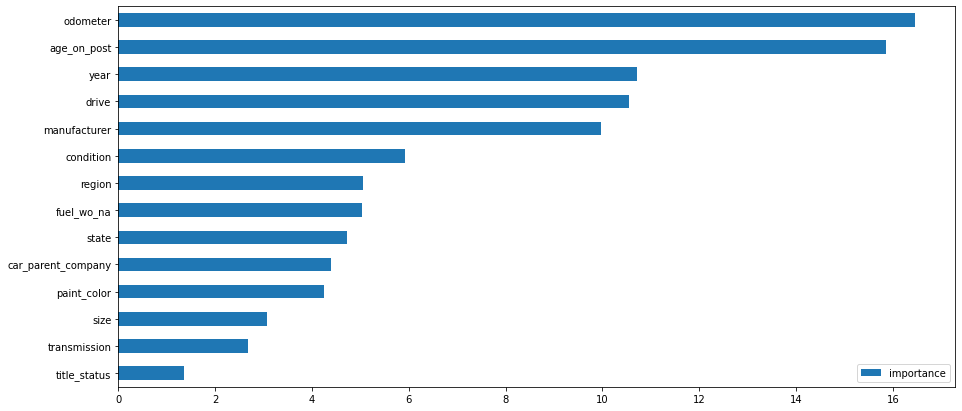

In [87]:
pd.DataFrame(
        data=model.feature_importances_,
        index=model.feature_names_,
        columns=['importance']
).sort_values(by='importance', ascending=True).plot(kind='barh');

As seen from the plot above, **the most important feature turned out to be the odometer reading** of the car, i.e. the number of kms it has run in its life; **barely winning the battle against the age of that car** on the date of ad post to be the most importance feature.

Other important features(in the order of importance) are:

- year of manufacture
- drive type (fwd, rwd, etc.)
- manufacturer company name
- condition of the car

What doesn't matter **that much**:

- region in which the ad was posted
- fuel type of the vehicle
- state in which the ad was posted
- car manufacturer's parent company
- body paint color of the car

What doesn't really affect the car price at all:

- car size (e.g.: Bentley Cooper is more expensive than a Toyota minivan)
- transmission: people really don't care whether the car is automatic or manual
- title status: people don't really care about this feature